In [1]:
%pylab inline

import os
from styles import slides
from astropy.io import fits
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
def equivalent_width(SED, centroids, widths):
    wl, fl = SED.T
    
    wl_in = array(centroids)-array(widths)*0.5
    wl_fi = array(centroids)+array(widths)*0.5
    
    EWs = zeros(len(centroids))
    for j in xrange(EWs.size):
        if wl_in[j]<wl[0] or wl_fi[j]>wl[-1]:
            EWs[j] = np.nan
            continue
        
        mask = (wl_in[j]<=wl)&(wl<=wl_fi[j])
        wl_m, fl_m = wl[mask], fl[mask]
        
        fl_c = fl_m[0] + (fl_m[-1]-fl_m[0])/(wl_m[-1]-wl_m[0])*(wl_m-wl_m[0])
        
        EWs[j] = trapz(1-fl_m/fl_c, wl_m)
    
    return np.abs(EWs)

In [3]:
rdir = os.path.expandvars("$HOME/Research/photometric-ew")

EWs = pd.read_csv("{}/data/photo-speclines.csv".format(rdir), index_col="FITS")
EWs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34462 entries, spSpec-51602-0266-012.fit.gz to spSpec-54650-2833-231.fit.gz
Data columns (total 50 columns):
OVI         0 non-null float64
Ly_alpha    0 non-null float64
NV          0 non-null float64
OI1306      0 non-null float64
CII1335     0 non-null float64
SiIV+OIV    0 non-null float64
CIV         0 non-null float64
HeII        0 non-null float64
OIII1665    0 non-null float64
AlIII       0 non-null float64
CIII        0 non-null float64
CII2326     0 non-null float64
NeIV        0 non-null float64
MgII        0 non-null float64
NeV3347     0 non-null float64
NeV3427     0 non-null float64
OII3727     33204 non-null float64
OII3730     33227 non-null float64
H_eta       34409 non-null float64
H_zeta      34430 non-null float64
HeI         34435 non-null float64
CaIIK       34432 non-null float64
CaIIH       34447 non-null float64
SII         34458 non-null float64
H_delta     34458 non-null float64
G           34461 non-null float64


In [4]:
fits_names = EWs.index.values
ur = EWs.u-EWs.r
mask = ur<2.22

ew_neb_mine = []
ew_neb_sdss = []
redshift = []
for i in xrange(500):
    with fits.open("{}/data/fits/{}".format(rdir, fits_names[mask][i])) as f:
        wlen = array([10**(f[0].header["COEFF0"]+f[0].header["COEFF1"]*j) for j in xrange(f[0].header["NAXIS1"])])
        #wlen /= 1.0 + 2.735182E-4 + 131.4182 / wlen**2 + 2.76249E8 / wlen**4
        flux = f[0].data[0]*1e-17
        sed_ = column_stack((wlen,flux))
        #print f[2].data["wave"][36]/(f[0].header["Z"]+1), f[2].data["restWave"][36]
        #ew_neb_mine += [equivalent_width(sed_, (6564.61/(1.0 + 2.735182E-4 + 131.4182 / f[2].data["Wave"][36]**2 + 2.76249E8 / f[2].data["Wave"][36]**4),), (100,))[0]]
        ew_neb_mine += [equivalent_width(sed_, (6564.61*(f[0].header["Z"]+1),), (20*(f[0].header["Z"]+1),))[0]]
        ew_neb_sdss += [abs(EWs.H_alpha.values[mask][i])]
        redshift += [f[0].header["Z"]]

ew_neb_mine = array(ew_neb_mine)
ew_neb_sdss = array(ew_neb_sdss)
redshift = array(redshift)

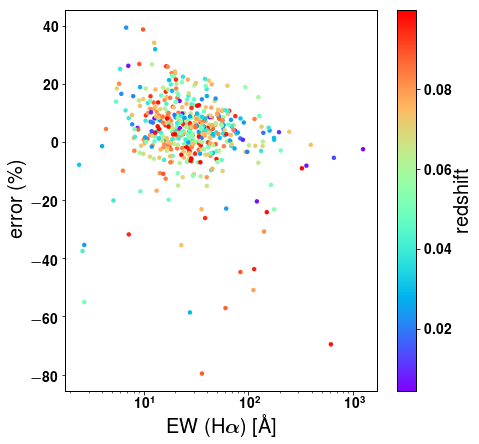

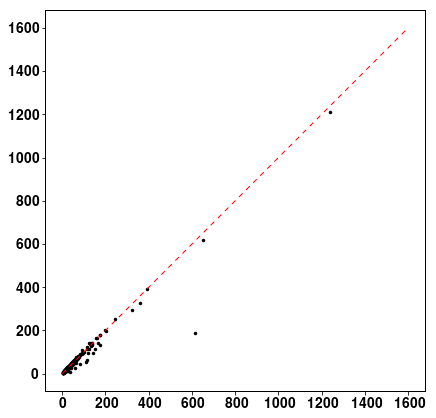

In [5]:
error = (ew_neb_mine - ew_neb_sdss)*100./ew_neb_sdss
mask = redshift<0.02
figure(figsize=(7,7))
scatter(ew_neb_sdss, error, lw=0, s=20, c=redshift, cmap=cm.rainbow)
cb = colorbar()
gca().set_xscale("log")
xlabel(r"EW (H$\alpha$) [\AA]")
ylabel(r"error (\%)")
cb.set_label(r"redshift")

figure(figsize=(7,7))
plot(ew_neb_sdss, ew_neb_mine, ".k", mew=0)
gca().set_aspect("equal")
plot([0,1600],[0,1600], ls=(0,(5,5)), color="r", lw=1.0)

(array([   0.,    0.,    1.,    1.,    4.,    2.,    5.,    7.,   15.,
         106.,  254.,   80.,   21.,    4.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([-100.,  -90.,  -80.,  -70.,  -60.,  -50.,  -40.,  -30.,  -20.,
         -10.,    0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,
          80.,   90.,  100.]),
 <a list of 20 Patch objects>)

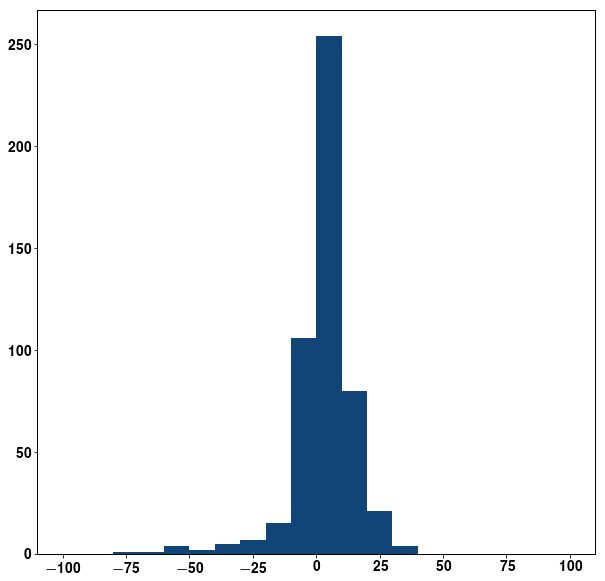

In [6]:
hist(error, 20, range=(-100,+100))